# 🍻 EDA & Test


In [1]:
import pandas as pd
import numpy as np
import base64
import IPython
from IPython.display import HTML, display

pd.set_option('display.max_colwidth', None)


def table_with_sound(dframe, audio_column='audio_column', pred=False):
    """
        Helper function for show dataframe with audio-play column
    """
    def path_to_sound_html(sound):
        encode_string = base64.b64encode(open(sound['Audio_Path'], "rb").read())
        encode_string = encode_string.decode("utf-8") 
        encode_string = 'data:audio/x-wav;base64,' +  encode_string
        return f'<audio controls ><source src={encode_string} type="audio/x-wav" />Your browser sucks!</audio> '

    dframe[audio_column] = dframe.apply(path_to_sound_html, axis=1)
    
    _columns = ['Audio_Name', 'Audio_Path', 'Emotion', 'Duration']
    if pred:
        _columns.append('Prediction')
    
    return HTML(dframe[_columns].to_html(escape=False))



In [2]:
ds_name = "ravdess" # < ---- ravdess | escorpus_pe | mess

path=f"/Users/beltre.wilton/apps/ftlab_w2v2_ser/rawdata/labels_{ds_name}/{ds_name}.csv"

df = pd.read_csv(path, names=['Audio_Path', 'Emotion', 'Duration'])
df.insert(1, 'Audio_Name', df['Audio_Path'].str.split('/').str[-1])
samples = df.sample(10)

display(HTML(f"<h2> ✨ {ds_name} dataset with {len(samples)} samples</h2></br>"))
table_with_sound(samples, "Audio_Path")

In [3]:
df.describe()

,Duration
count,1440.000000
mean,3.700665
std,0.336676
min,2.936271
25%,3.470146
50%,3.670333
75%,3.870542
max,5.271937


Text(0.5, 0, 'Duration in seconds')

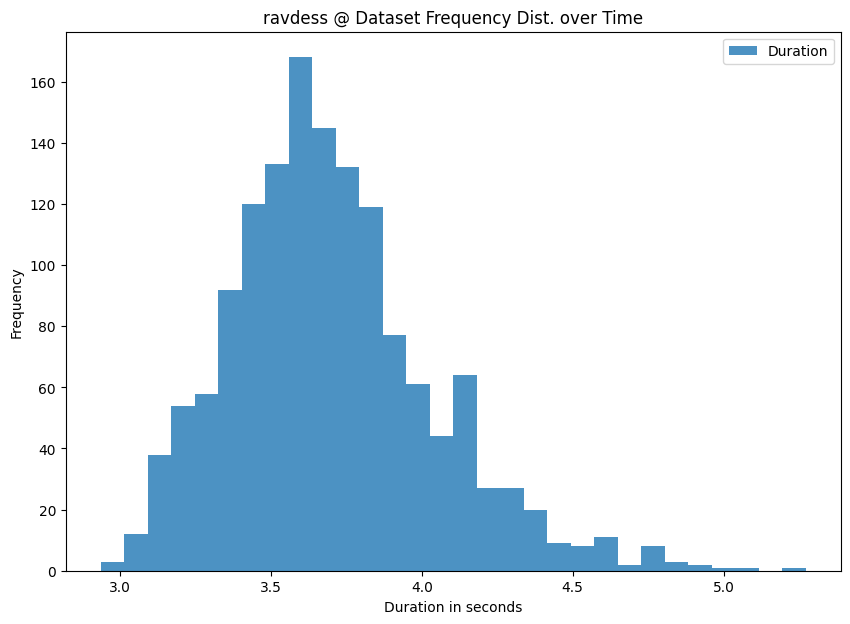

In [4]:
ax = df.plot.hist(bins=30, alpha=0.8, figsize=(10, 7))
ax.set_title(f"{ds_name} @ Dataset Frequency Dist. over Time")
ax.set_xlabel("Duration in seconds")


<Axes: title={'center': 'ravdess @ pie % emotions Ekman Basic 6 model '}, ylabel='count'>

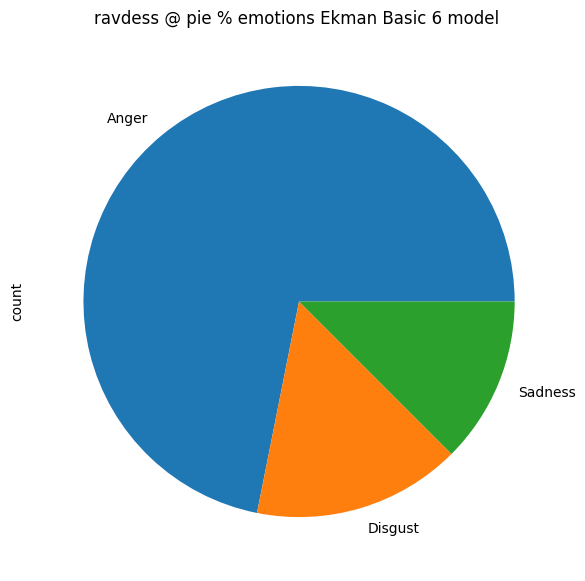

In [5]:
emo_method = "Ekman Basic 6 model" if len(df.Emotion.value_counts()) < 7 else "Russell & Mehrabian (mappep to categorical)"
df.Emotion.value_counts().plot(kind='pie', figsize=(7, 7), title=f"{ds_name} @ pie % emotions {emo_method} ")

## 🪄 Inference

In [6]:
import torch
import numpy as np
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import time
from dotmap import DotMap
from torch.utils.data import DataLoader
from torchviz import make_dot
from train.rnn_head import RNNHead
from train.custom_dataset import CustomDataset
from train.main_impl import MainImplementation



### Hyperparameters
hparams = DotMap()
hparams.batch_size = 64
hparams.lr = 1e-4
hparams.maxseqlen = 10 # check the avg of the all audios.
hparams.nworkers = 1 # it was 4
hparams.precision = 32
hparams.saving_path = 'downstream/checkpoints/custom'
hparams.audiopath = f"/Users/beltre.wilton/apps/ftlab_w2v2_ser/rawdata/{ds_name}_16k"
hparams.labelpath = f"/Users/beltre.wilton/apps/ftlab_w2v2_ser/rawdata/labels_{ds_name}/{ds_name}.json"
hparams.pretrained_path = "/Users/beltre.wilton/apps/ftlab_w2v2_ser/pretrained_path/wav2vec2-base"
hparams.model_type = 'wav2vec2'
hparams.save_top_k = 1
hparams.num_exps = 1
hparams.outputfile = f"log_file_{time.time_ns()}.log"


dataset = CustomDataset(hparams.audiopath, hparams.labelpath, maxseqlen=hparams.maxseqlen)
loader = DataLoader(dataset=dataset.test_dataset, batch_size=1, drop_last=False)
chkpt = "/Users/beltre.wilton/apps/ftlab_w2v2_ser/downstream/checkpoints/custom/ravdess-epoch=06-valid_loss=0.284-valid_UAR=0.91667.ckpt"
model = MainImplementation.load_from_checkpoint(chkpt, hparams=hparams, inference=True)

def generate_samples(n_samples):
    output = []
    
    for i in range(n_samples):
        audio, label, label_str, wav_name, duration = dataset.test_dataset.get_sample()
        lenght = torch.LongTensor([audio.size(1)])
    
        pred = model(audio, lenght)
    
        y_hat = np.argmax(pred.detach().numpy())
        y_hat_str = dataset.test_dataset.to_label(y_hat)
        output.append(['', wav_name, label_str, y_hat_str, duration])
    
    return output




/Users/beltre.wilton/miniforge3/envs/ftlab_w2v2_ser_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Statistics of training splits:
----Involved Emotions----
Anger: 654 examples
Sadness: 120 examples
Disgust: 147 examples
Total 921 examples
----Examples Involved----

Statistics of validation splits:
----Involved Emotions----
Anger: 171 examples
Disgust: 32 examples
Sadness: 28 examples
Total 231 examples
----Examples Involved----

Statistics of testing splits:
----Involved Emotions----
Disgust: 46 examples
Anger: 210 examples
Sadness: 32 examples
Total 288 examples
----Examples Involved----

Statistics of training splits:
----Involved Emotions----
Anger: 654 examples
Sadness: 120 examples
Disgust: 147 examples
Total 921 examples
----Examples Involved----

Statistics of validation splits:
----Involved Emotions----
Anger: 171 examples
Disgust: 32 examples
Sadness: 28 examples
Total 231 examples
----Examples Involved----

Statistics of testing splits:
----Involved Emotions----
Disgust: 46 examples
Anger: 210 examples
Sadness: 32 examples
Total 288 examples
----Examples Involved----



/Users/beltre.wilton/miniforge3/envs/ftlab_w2v2_ser_env/lib/python3.10/site-packages/transformers/configuration_utils.py:380: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [7]:
def check_mark(row):
  label = f"{row.Prediction} ✅ " if row.Prediction == row.Emotion else f"{row.Prediction} ❌" 
  return label


n_samples = 10
output = generate_samples(n_samples)
_columns = ['Audio_Name', 'Audio_Path', 'Emotion', 'Prediction', 'Duration']
df_samples = pd.DataFrame(data=output, columns=_columns)
df_samples['Prediction'] = df_samples.apply(lambda row: check_mark(row), axis=1)


display(HTML(f"<h2> ✨ Inference @ {ds_name} dataset with {n_samples} samples</h2></br>"))
table_with_sound(df_samples, audio_column="Audio_Path", pred=True)
